In [1]:
import torch
from torch import nn
import numpy as np
from torch.distributions import Normal, Laplace
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import seaborn as sns

In [2]:
from bernstein_transformation_layer import *
from training_helpers import *

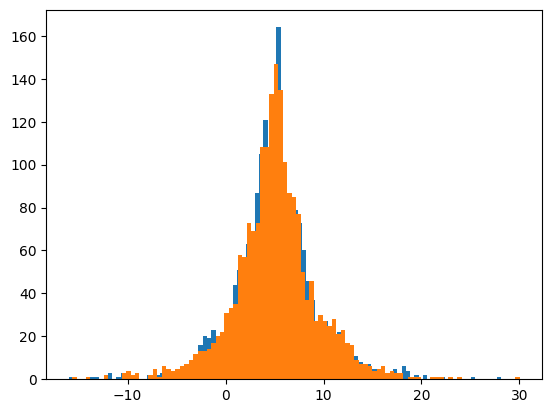

In [3]:
y_distribution = Laplace(5, 3)
y = y_distribution.sample((2000,2)) # Generate training data
plt.hist(y[:,0].numpy(), bins=100)
plt.hist(y[:,1].numpy(), bins=100)
plt.show()

In [6]:
polynomial_range = torch.FloatTensor([[-40, -40],
                                          [40, 40]])
mctm = Transformation(degree=10, number_variables=2, polynomial_range=polynomial_range)

In [7]:
loss = train(mctm, y, iterations=120, verbose=False)

  7%|▋         | 8/120 [00:05<01:20,  1.39it/s]


ValueError: Expected value argument (Tensor of shape (2000, 2)) to be within the support (Real()) of the distribution Normal(loc: 0.0, scale: 1.0), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<CopySlices>)

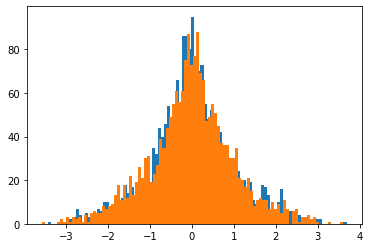

In [12]:
z, log_d = mctm.forward(y)
plt.hist(z[:,0].detach().numpy(), bins=100)
plt.hist(z[:,1].detach().numpy(), bins=100)
plt.show()

In [13]:
import statsmodels.api as sm

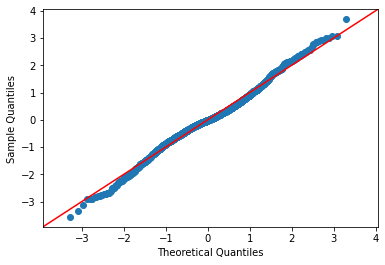

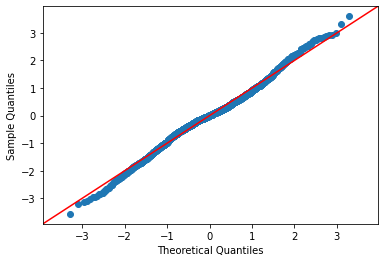

In [14]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(z[:,0].detach().numpy(), line='45')
plt.show()
fig = sm.qqplot(z[:,1].detach().numpy(), line='45')
plt.show()

In [15]:
polynomial_range = torch.FloatTensor([[-10, -10],
                                          [10, 10]])
mctm.approximate_inverse(y, polynomial_range_inverse= polynomial_range, iterations=5000)
# use cubic splines for approx?
# use linespace to have more observations to train on?
# how is it done in the tensorflow implementation

  3%|▎         | 135/5000 [00:06<03:49, 21.18it/s]


KeyboardInterrupt: 

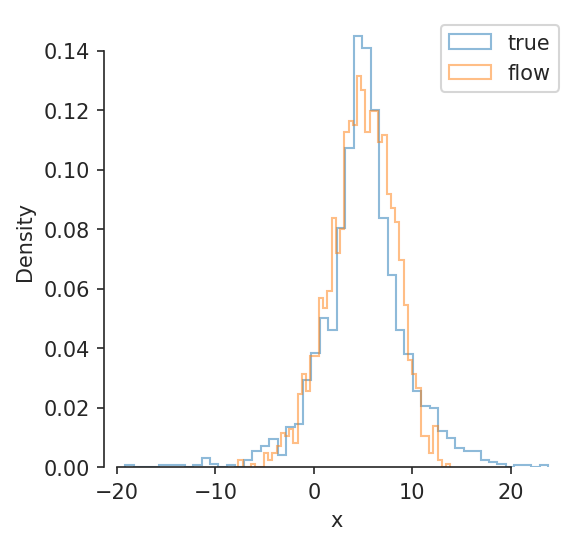

In [48]:
evaluate(mctm)

In [35]:
def multivariable_lambda_prediction(input, degree, number_variables, params, polynomial_range, inverse=False, spline="bspline"):

    #steps
    output = input.clone()
    # loop over all variables
    params_index = 0

    for var_num in range(number_variables):
        #print(var_num)
        # loop over all before variables
        for covar_num in range(var_num):
            #print(covar_num)
            #print(params_index)

            # compute lambda fct value using before variable
            if inverse:
                #output into spline
                if spline == "bspline":
                    lambda_value = bspline_prediction(params[:, params_index], output[:,covar_num], degree, polynomial_range[:,covar_num], monotonically_increasing=False, derivativ=0)
                elif spline == "bernstein":
                    lambda_value = bernstein_prediction(params[:, params_index], output[:,covar_num], degree, polynomial_range[:,covar_num], monotonically_increasing=False, derivativ=0)
            else:
                #input into spline
                if spline == "bspline":
                    lambda_value = bspline_prediction(params[:, params_index], input[:,covar_num], degree, polynomial_range[:,covar_num], monotonically_increasing=False, derivativ=0)
                elif spline == "bernstein":
                    lambda_value = bernstein_prediction(params[:, params_index], input[:,covar_num], degree, polynomial_range[:,covar_num], monotonically_increasing=False, derivativ=0)

            # update
            # Cloning issue?
            if inverse:
                output[:,var_num] = output[:,var_num] - lambda_value * output[:,covar_num]
            else:
                output[:,var_num] = output[:,var_num] + lambda_value * input[:,covar_num]

            params_index += 1

    return output

class Decorrelation(nn.Module):
    def __init__(self, degree, number_variables, polynomial_range, spline="bspline"):
        super().__init__()
        self.degree  = degree
        self.number_variables = number_variables
        self.polynomial_range = polynomial_range
        self.num_lambdas = number_variables * (number_variables-1) / 2
        self.spline = spline
        # https://discuss.pytorch.org/t/how-to-turn-list-of-varying-length-tensor-into-a-tensor/1361
        # param dims: 0: basis, 1: variable
        p = torch.FloatTensor(np.repeat(np.repeat(0.1,self.degree+1), self.num_lambdas))

        if self.num_lambdas == 1:
            self.params = nn.Parameter(p.unsqueeze(1))
        else:
            self.params = nn.Parameter(torch.reshape(p,(self.degree+1, int(self.num_lambdas))))

    def forward(self, input, log_d = 0, inverse = False):
        if not inverse:
            output = multivariable_lambda_prediction(input, self.degree, self.number_variables, self.params, self.polynomial_range, inverse=False, spline=self.spline)
        else:
            output = multivariable_lambda_prediction(input, self.degree, self.number_variables, self.params, self.polynomial_range, inverse=True, spline=self.spline)
        return output, log_d


In [8]:
from decorrelation_layer import *

In [9]:
from torch.distributions.multivariate_normal import MultivariateNormal
loc = torch.zeros(3)
lam = torch.Tensor([[1, 0, 0],
                    [3, 1, 0],
                    [0, 0, 1]])
scale = lam @ torch.eye(3) @ torch.transpose(lam,0,1)
y_distribution = MultivariateNormal(loc, scale)
y = y_distribution.sample((2000,1)) # Generate training data
y = y.reshape((2000,3))
y.size()

torch.Size([2000, 3])

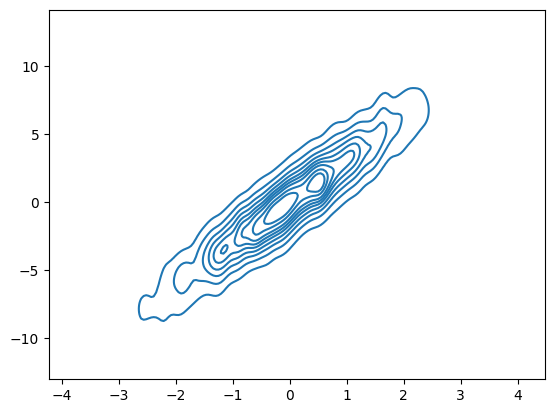

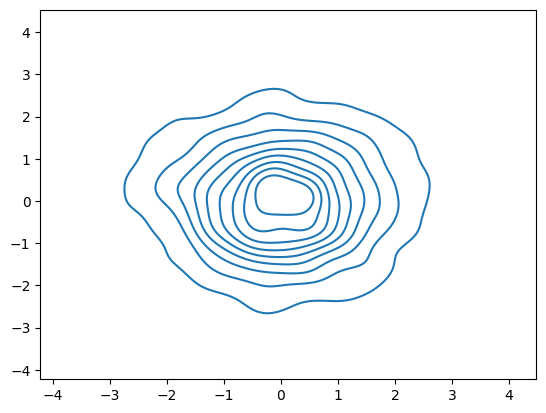

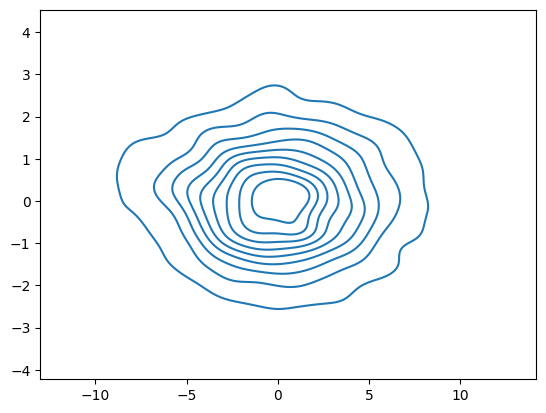

In [10]:
sns.kdeplot(x=y[:,0], y=y[:,1])
plt.show()
sns.kdeplot(x=y[:,0], y=y[:,2])
plt.show()
sns.kdeplot(x=y[:,1], y=y[:,2])
plt.show()

In [13]:
polynomial_range = torch.FloatTensor([[-15, -15, -15],
                                          [15, 15, 15]])
decorr = Decorrelation(degree=12, number_variables=3, polynomial_range=polynomial_range, spline="bspline")

In [14]:
train(decorr, y, iterations=200, verbose=False)

  0%|          | 1/200 [02:01<6:42:07, 121.25s/it]


KeyboardInterrupt: 

In [9]:
decorr = Decorrelation(degree=10, number_variables=3, polynomial_range=polynomial_range, spline="bspline")

 55%|█████▌    | 110/200 [00:43<00:35,  2.54it/s]


Early Stop!


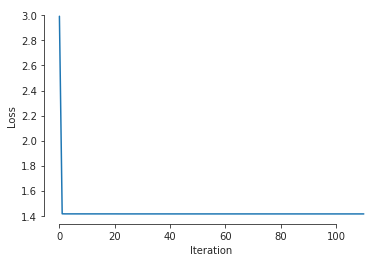

In [10]:
train(decorr, y, iterations=200, verbose=False)

In [11]:
decorr.params

Parameter containing:
tensor([[ 0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  1.2899],
        [ 0.1000,  0.1000, -0.1314],
        [-1.1455, -3.5968,  0.0571],
        [-2.8777,  0.4060, -0.1192],
        [-3.2153,  0.0594,  0.0698],
        [-2.7429,  0.1996, -0.0935],
        [-3.1027,  2.2726, -0.0110],
        [ 0.1000,  0.1000, -0.3197],
        [ 0.1000,  0.1000,  0.7458],
        [ 0.1000,  0.1000,  0.1000]], requires_grad=True)

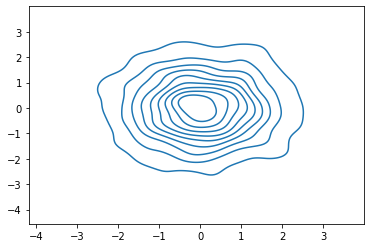

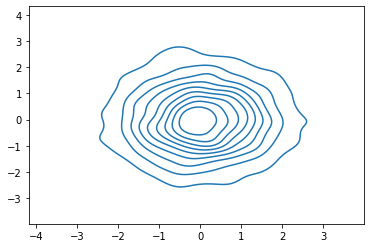

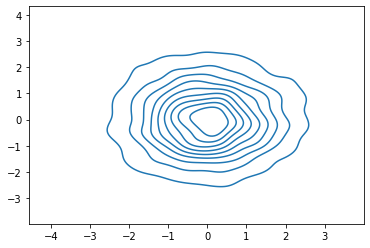

In [12]:
z, log_d = decorr.forward(y)
z = z.detach().numpy()
sns.kdeplot(x=z[:,0], y=z[:,1])
plt.show()
sns.kdeplot(x=z[:,0], y=z[:,2])
plt.show()
sns.kdeplot(x=z[:,1], y=z[:,2])
plt.show()

In [4]:
from torch.distributions.multivariate_normal import MultivariateNormal
loc = torch.zeros(2)
lam = torch.Tensor([[1, 0],
                    [1.5, 1]])
scale = lam @ torch.eye(2) @ torch.transpose(lam,0,1)
y_distribution = MultivariateNormal(loc, scale)
y = y_distribution.sample((2000,1)) # Generate training data
y = y.reshape((2000,2))
y.size()

torch.Size([2000, 2])

In [22]:
polynomial_range = torch.FloatTensor([[-10],[10]])
decorr = Decorrelation(degree=12, number_variables=2, polynomial_range=polynomial_range)

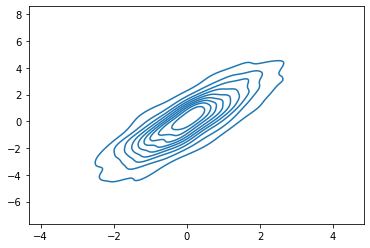

In [5]:
sns.kdeplot(x=y[:,0], y=y[:,1])
plt.show()

 24%|██▍       | 24/100 [00:05<00:16,  4.62it/s]

Early Stop!


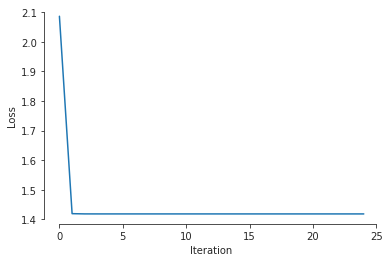

In [24]:
train(decorr, y, iterations=100, verbose=False)

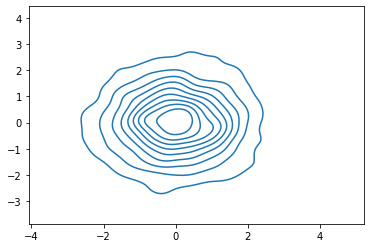

In [25]:
z, log_d = decorr.forward(y)
z = z.detach().numpy()
sns.kdeplot(x=z[:,0], y=z[:,1])
plt.show()

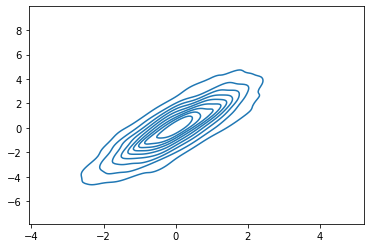

In [27]:
z, log_d = decorr.forward(y)
y_hat, log_d = decorr.forward(z.detach(), inverse=True)
#require z.detach() in the backward pass for the bspline code

y_hat = y_hat.detach().numpy()
sns.kdeplot(x=y_hat[:,0], y=y_hat[:,1])
plt.show()

In [31]:
# Inverse works!
y_hat, log_d = decorr.forward(z.detach(), inverse=True)
y == y_hat
# why a false at the last position? even though the same
y[y.size(0)-1,:]
y_hat[y_hat.size(0)-1,:]

tensor([[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True, False]])

In [6]:
class Flip(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return torch.flip(x, [0])

In [43]:
class NF_MCTM(nn.Module):
    def __init__(self, polynomial_range, number_variables):
        super(NF_MCTM, self).__init__()
        self.polynomial_range = polynomial_range
        self.number_variables = number_variables

        self.model = nn.Sequential(
            Transformation(degree=10, number_variables=self.number_variables, polynomial_range=self.polynomial_range.repeat(1,3)),
            Decorrelation(degree=12, number_variables=self.number_variables, polynomial_range=self.polynomial_range.repeat(1,3), spline="bernstein"),
            Flip(),
            Decorrelation(degree=12, number_variables=self.number_variables, polynomial_range=self.polynomial_range.repeat(1,3), spline="bernstein"),
            Flip(),
            Decorrelation(degree=12, number_variables=self.number_variables, polynomial_range=self.polynomial_range.repeat(1,3), spline="bernstein"),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [44]:
nf_mctm = NF_MCTM(polynomial_range = torch.tensor([[-10],[10]]), number_variables=3)

In [46]:
torch.tensor([[-10],[10]]).repeat([1,3])

tensor([[-10, -10, -10],
        [ 10,  10,  10]])

In [34]:
y.size()

torch.Size([2000, 3])

In [45]:
nf_mctm.forward(y)

AttributeError: 'tuple' object has no attribute 'clone'

In [47]:
torch.flip(y, [0])

tensor([[-1.1932, -0.8018],
        [ 0.8045,  0.8068],
        [-2.0925, -2.6940],
        ...,
        [-1.5152, -2.0197],
        [ 0.4196,  0.3493],
        [-0.4228, -0.3820]])